In [1]:
example_date = '2015-11-01'
gtfs_path = '/gpfs2/projects/project-bus_capstone_2016/workspace/share/gtfs/'
code_filepath = '..'
avl_sample = '/gpfs2/projects/project-bus_capstone_2016/workspace/share/old_junk/20151101_parsed.csv'

import os
import pandas as pd
import numpy as np
%matplotlib inline

# these two modules are homemade
os.chdir(code_filepath)
import ttools #homemade module
import gtfs #homemade module

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips(example_date,gtfs_path)
stops = gtfs.load_stops(example_date,gtfs_path)
stop_times, tz_sched = gtfs.load_stop_times(example_date,gtfs_path)
tcal = gtfs.TransitCalendar(example_date,gtfs_path)
print 'Finished loading GTFS data.'

Finished loading GTFS data.


# get the sample of parsed AVL data.
Clean MTA prefixes from trip_id

In [3]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv(avl_sample)

### Warning, this demonstration uses a dataframe index that was deprecated.

In [4]:
bustime.columns = ['vehicle_id','route','timestamp','lat','lon','trip_id','trip_date','shape_id',
                   'next_stop_id','est_arrival','dist_from_stop','stop_dist_on_trip','presentable_dist','response']
bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)

In [5]:
bustime.groupby(level=2).size()

trip_date
2015-10-31     59293
2015-11-01    846834
2015-11-02        57
dtype: int64

In [6]:
# for demonstration, use a subset. Just get data for one trip-date.
tripDateLookup = "2015-11-01" # this is a non-holiday Monday
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
bustime.sort_index(inplace=True)
print 'Finished loading BusTime data and and slicing one day.'

Finished loading BusTime data and and slicing one day.


## Compare list of trip_id between GTFS schedule and BusTime reported data.
First just compare the length of the lists.

In [8]:
# Filter the service_ids for those applicable to this date
# gtfs.TransitCalendar class now correctly adjusts for exception dates
active_services = tcal.get_service_ids('2015-11-01') 
# Load a sepate trips dataframe but use only one index level
trips_ = gtfs.load_trips(example_date,gtfs_path).reset_index().set_index(['service_id'])
# Generate list of all trip_ids that are scheduled for those service_ids
gtfs_trip_ids = trips_.loc[active_services]['trip_id'].unique()
# Generate list of all trip_ids in BusTime subset
bustime_trip_ids = bustime.index.get_level_values(1).unique()

In [9]:
len(gtfs_trip_ids)

32692

In [10]:
len(bustime_trip_ids)

30389

## Much smaller difference in trip lists using the recent sample
Return the non-matching trip_ids and describe a few things about those trips, based on the GTFS data.

In [11]:
# parse times into numeric
ts_parsed = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-11-01')

### Plot distribution of BusTime pings throughout the day.  Look for sudden dips (gaps).

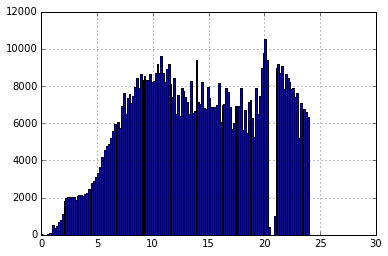

In [12]:
(ts_parsed/ttools.datetime.timedelta(hours=1)).hist(range=(0,30),bins=180)

The mid-day gap could be due to the schedule.  Peaks are clearly around rush-hours.
### Get the trip_id labels from GTFS which are not found anywhere in BusTime data

In [13]:
set1 = set(gtfs_trip_ids)
set2 = set(bustime_trip_ids)

unmatched = set1.symmetric_difference(set2) # goes both ways
len(unmatched)

2303

Show routes with percentage of trips missing any data

In [14]:
pct_missing_by_route = trips.loc[unmatched].groupby('route_id').size()/trips.groupby('route_id').size()
pct_missing_by_route.sort(ascending=False)
pct_missing_by_route

route_id
B32      0.041379
Q102     0.036613
Q15A     0.034667
Q12      0.032725
Q13      0.031881
M35      0.029489
Q15      0.028133
M60+     0.025103
Q3       0.023859
S52      0.023283
M72      0.022590
BX18     0.021684
Q44      0.021555
Q20A     0.020958
Q32      0.020765
Q18      0.019908
Q84      0.018349
BXM1     0.016807
Q22      0.016094
M20      0.015611
Q50      0.015184
M57      0.015162
M116     0.015102
Q83      0.014469
Q19      0.014245
M104     0.014124
Q27      0.013975
Q47      0.013932
M34A+    0.013271
S59      0.012927
           ...   
S96           NaN
S98           NaN
X10           NaN
X10B          NaN
X11           NaN
X12           NaN
X14           NaN
X15           NaN
X17A          NaN
X17J          NaN
X19           NaN
X2            NaN
X21           NaN
X22           NaN
X22A          NaN
X28           NaN
X3            NaN
X30           NaN
X31           NaN
X37           NaN
X38           NaN
X4            NaN
X42           NaN
X5            NaN
X

### Show distribution of missing data according to the hour of service (based on stop times)
This should be roughly inverse to the data density plotted initially.

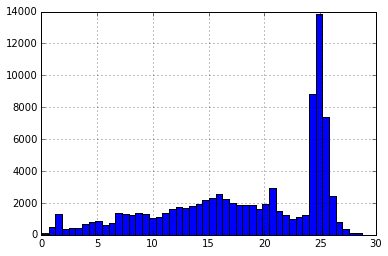

In [15]:
stop_hour = stop_times.reset_index().set_index('trip_id')['arrival_time'].apply(ttools.parseTime)/ttools.datetime.timedelta(hours=1)
stop_hour.loc[unmatched].hist(bins=48)

### Compare distributions of trip duration, all trips from GTFS versus the missing trips. 

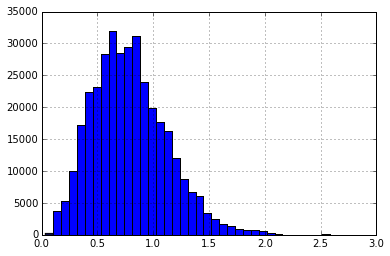

In [16]:
# Distribution of trip durations - ALL scheduled trips
pd.Series(stop_hour.groupby(level=0).max() - stop_hour.groupby(level=0).min()).hist(bins=40)

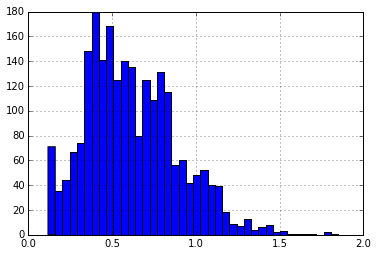

In [17]:
# Distribution of trip durations - MISSING trips only
pd.Series(stop_hour.loc[unmatched].groupby(level=0).max() - stop_hour.loc[unmatched].groupby(level=0).min()).hist(bins=40)

## Analyze expected trip data-density, but agnostic to trip_id
Plot a comparison (GTFS versus BusTime) of how many vehicles are on an active trip throughout the day.

In [18]:
gtfs_trip_ids[16130] = ''
str_list = filter(None, gtfs_trip_ids)

In [19]:
len(str_list)

32691

In [20]:
gtfs_trip_ids = np.asarray(str_list)

In [27]:
start_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).min()).apply(np.floor).dropna().astype(int)
end_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).max()).apply(np.floor).dropna().astype(int)

In [28]:
# time is divided into bins of 0.1 hours (6 minutes)
# make a 2D binary matrix indicating when the trip is active during each time bin.
time_bin_matrix = np.zeros((len(start_bins),max(end_bins)+1))
counter = 0
for i,v_start in start_bins.iteritems():
    v_end = end_bins.loc[i]
    time_bin_matrix[counter,v_start:v_end] = 1
    counter += 1

Now do the same from the BusTime data.  Danger - vehicles may be recording data even when not on an active trip.

In [29]:
start_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).min()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
end_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).max()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
time_bin_matrix_bustime = np.zeros((len(start_bins_bustime),max(end_bins_bustime)+1))
counter = 0
for i,v_start in start_bins_bustime.iteritems():
    v_end = end_bins_bustime.loc[i]
    time_bin_matrix_bustime[counter,v_start:v_end] = 1
    counter += 1

### Plot the comparison.
Note that the BusTime data tracks the expected density nicely.

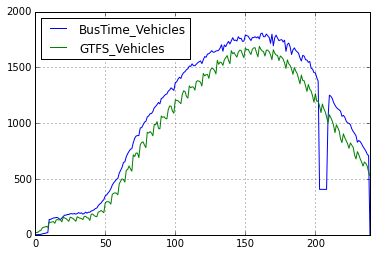

In [30]:
pd.DataFrame(time_bin_matrix_bustime.sum(axis=0),columns=['BusTime_Vehicles']).join(pd.Series(time_bin_matrix.sum(axis=0),name='GTFS_Vehicles')).plot()